# Expected Calibration Error computation

In [2]:
!pip install pycocotools tqdm tidecv

In [92]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from tidecv import TIDE, datasets

from dataclasses import dataclass
from typing import List, Tuple, Dict, Set
from tqdm import tqdm
from collections import defaultdict

import pandas as pd
import json

# Problem 1: Expected Calibration Error (ECE)

ECE is a metric to evaluate the calibration of a model. It is defined as the expected value of the absolute difference between the accuracy and the confidence of the model. The confidence of the model is the probability assigned to the predicted class. The accuracy is 1 if the prediction is correct and 0 otherwise. The ECE is computed by dividing the confidence interval [0, 1] into M equally spaced bins and computing the weighted average of the absolute difference between the accuracy and the confidence in each bin. The weights are the proportion of samples in each bin. The ECE is defined as:

\begin{equation}
ECE = \sum_{m=1}^{M} \frac{B_m}{N} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
\end{equation}

where $B_m$ is the set of samples in bin $m$, $N$ is the total number of samples, $\text{acc}(B_m)$ is the accuracy of the model in bin $m$, and $\text{conf}(B_m)$ is the confidence of the model in bin $m$. The accuracy and confidence in bin $m$ are defined as:

\begin{equation}
\text{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbb{1} \left( y_i = \hat{y}_i \right)
\end{equation}

\begin{equation}
\text{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} p_i
\end{equation}

where $y_i$ is the true label of sample $i$, $\hat{y}_i$ is the predicted label of sample $i$, $p_i$ is the confidence of the model for sample $i$, and $\mathbb{1}(\cdot)$ is the indicator function.


## Starter Code

The following section contains some starter code to help you prepare the data using the COCO API. You can use this code to preprocess the data, or you can write your own code.

In [4]:
@dataclass
class Detection:
    bbox: np.ndarray  # [x1, y1, x2, y2]
    class_id: int
    confidence: float

@dataclass
class GroundTruth:
    bbox: np.ndarray  # [x1, y1, x2, y2]
    class_id: int

In [5]:
def coco_to_corners(bbox):
    """Convert COCO bbox [x,y,w,h] to corners format [x1,y1,x2,y2]"""
    return np.array([
        bbox[0],
        bbox[1],
        bbox[0] + bbox[2],
        bbox[1] + bbox[3]
    ])

def get_image_annotations(coco_gt, coco_dt, img_id, max_dets=100):
    """Get list of ground truth and detection annotations across all images"""
    gt_ids = coco_gt.getAnnIds(imgIds=img_id)
    gt_anns = coco_gt.loadAnns(gt_ids)
    gts = [
        GroundTruth(
            bbox=coco_to_corners(ann['bbox']),
            class_id=ann['category_id']
        )
        for ann in gt_anns
    ]

    # Get detections
    dt_ids = coco_dt.getAnnIds(imgIds=img_id)
    dt_anns = coco_dt.loadAnns(dt_ids)
    if max_dets is not None:
        dt_anns = sorted(dt_anns, key=lambda x: x['score'], reverse=True)[:max_dets]
    dets = [
        Detection(
            bbox=coco_to_corners(ann['bbox']),
            class_id=ann['category_id'],
            confidence=ann['score']
        )
        for ann in dt_anns
    ]

    return gts, dets

def prepare_inputs(coco_gt, coco_dt, max_dets=100):
    """Convert COCO format to TIDE format for all images"""
    all_gts = []
    all_dets = []

    for img_id in tqdm(coco_gt.getImgIds(), desc="Processing images"):
        gts, dets = get_image_annotations(coco_gt, coco_dt, img_id, max_dets)
        all_gts.extend(gts)
        all_dets.extend(dets)

    return all_gts, all_dets

In [7]:
predictions_json = "runs/detect/val/predictions.json"   # Path to the predictions JSON file
ground_truth_json = "datasets/coco/annotations/instances_val2017.json"  # Path to the val annotations JSON file

coco_gt = COCO(ground_truth_json)       # Load ground truth annotations
coco_dt = coco_gt.loadRes(predictions_json) # Load predictions

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
Loading and preparing results...
DONE (t=4.69s)
creating index...
index created!


In [8]:
gts, dets = prepare_inputs(coco_gt, coco_dt, max_dets=100)
len(gts), len(dets)

Processing images:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing images: 100%|██████████| 5000/5000 [00:01<00:00, 3788.06it/s]


(36781, 411475)

## Expected Calibration Error.

In [104]:
def is_accurate(df, image_id, bbox_pred, category_id):
    bbox_list = df.loc[df['image_id'] == image_id, 'bbox'].tolist()
    category_list = df.loc[df['image_id'] == image_id, 'category_id'].tolist()
    max_IoU = 0
    category = -1
    for i in range(len(bbox_list)):
        x1_pred, y1_pred, x2_pred, y2_pred = coco_to_corners(bbox_pred)
        x1_gt, y1_gt, x2_gt, y2_gt = coco_to_corners(bbox_list[i])

        x1_int = max(x1_gt, x1_pred)
        y1_int = max(y1_gt, y1_pred)
        x2_int = min(x2_gt, x2_pred)
        y2_int = min(y2_gt, y2_pred)

        intersection_area = max(0, x2_int - x1_int) * max(0, y2_int - y1_int)
        union_area = max(0, x2_gt - x1_gt) * max(0, y2_gt - y1_gt) + max(0, x2_pred - x1_pred) * max(0, y2_pred - y1_pred)
        IoU = 0 if union_area == 0 else intersection_area / union_area
    
        if IoU > max_IoU:
            max_IoU = IoU
            category = category_list[i]
    
    if category_id == category:
        return 1
    else:
        return 0

In [105]:
with open(predictions_json, "r") as file:
    data_pred = json.load(file)
num_samples = len(data_pred)
print(f"Number of samples are {num_samples}")

df_pred = pd.DataFrame(data_pred)
print(df_pred)

Number of samples are 851240
        image_id  category_id                                bbox    score
0         298251           24     [69.854, 91.565, 68.42, 43.576]  0.93079
1         298251           24    [521.027, 105.175, 42.0, 41.631]  0.90743
2         298251            1    [561.081, 63.01, 11.872, 40.281]  0.58532
3         298251            1   [378.665, 65.115, 16.121, 36.537]  0.57839
4         298251           24   [561.087, 62.432, 20.876, 40.842]  0.51410
...          ...          ...                                 ...      ...
851235     42102           85  [173.891, 178.787, 12.252, 24.916]  0.00117
851236     42102           33   [11.28, 374.686, 57.911, 191.473]  0.00115
851237     42102           32   [104.946, 90.584, 43.416, 29.722]  0.00114
851238     42102           42  [31.235, 371.127, 154.412, 210.29]  0.00111
851239     42102            1    [69.806, 47.244, 36.933, 65.589]  0.00101

[851240 rows x 4 columns]


In [106]:
with open(ground_truth_json, "r") as file:
    data_gt = json.load(file)
df_gt = pd.DataFrame(data_gt['annotations'])
print(df_gt)

                                            segmentation          area  \
0      [[510.66, 423.01, 511.72, 420.03, 510.45, 416....     702.10575   
1      [[289.74, 443.39, 302.29, 445.32, 308.09, 427....   27718.47630   
2      [[147.76, 396.11, 158.48, 355.91, 153.12, 347....   78969.31690   
3      [[260.4, 231.26, 215.06, 274.01, 194.33, 307.6...  108316.66515   
4      [[200.61, 253.97, 273.19, 318.49, 302.43, 336....   75864.53530   
...                                                  ...           ...   
36776  {'counts': [94823, 6, 473, 8, 471, 10, 469, 11...    3773.00000   
36777  {'counts': [277, 2, 361, 9, 1, 17, 3, 17, 3, 8...  112181.00000   
36778  {'counts': [2770, 6, 418, 8, 416, 10, 86, 6, 3...   47024.00000   
36779  {'counts': [3912, 10, 363, 18, 356, 23, 301, 1...   27277.00000   
36780  {'counts': [179, 27, 392, 41, 380, 51, 371, 59...  220834.00000   

       iscrowd  image_id                              bbox  category_id  \
0            0    289343    [473.07,

In [107]:
df_pred['acc'] = df_pred.apply(lambda row: is_accurate(df_gt, row['image_id'], row['bbox'], row['category_id']), axis=1)

In [108]:
num_bins = 75
scores = [entry["score"] for entry in data_pred]
bins = [i / num_bins for i in range(num_bins+1)]
labels = [i for i in range(len(bins) - 1)]
df_pred["bin"] = pd.cut(df_pred["score"], bins=bins, labels=labels, include_lowest=True)

In [109]:
df_pred.to_json("dataframe.json", orient="records", indent=4)

In [110]:
print(df_pred)

        image_id  category_id                                bbox    score  \
0         298251           24     [69.854, 91.565, 68.42, 43.576]  0.93079   
1         298251           24    [521.027, 105.175, 42.0, 41.631]  0.90743   
2         298251            1    [561.081, 63.01, 11.872, 40.281]  0.58532   
3         298251            1   [378.665, 65.115, 16.121, 36.537]  0.57839   
4         298251           24   [561.087, 62.432, 20.876, 40.842]  0.51410   
...          ...          ...                                 ...      ...   
851235     42102           85  [173.891, 178.787, 12.252, 24.916]  0.00117   
851236     42102           33   [11.28, 374.686, 57.911, 191.473]  0.00115   
851237     42102           32   [104.946, 90.584, 43.416, 29.722]  0.00114   
851238     42102           42  [31.235, 371.127, 154.412, 210.29]  0.00111   
851239     42102            1    [69.806, 47.244, 36.933, 65.589]  0.00101   

        acc bin  
0         1  69  
1         1  68  
2        

In [113]:
bin_sizes = df_pred["bin"].value_counts().sort_index().to_list()
bin_acc = df_pred.groupby("bin", observed=True)["acc"].sum().to_list()
bin_conf = df_pred.groupby("bin", observed=True)["score"].sum().to_list()

ECE = 0
for i in range(num_bins-1):
    ECE += abs(bin_acc[i] - bin_conf[i]) / sum(bin_sizes)
print(ECE)

0.2706045977515154


In [115]:
print(bin_sizes)
print(bin_acc)
print(bin_conf)

[631132, 84476, 34529, 19305, 12300, 8747, 6566, 4879, 4073, 3355, 2705, 2375, 1963, 1742, 1535, 1369, 1189, 1187, 1046, 931, 875, 922, 735, 700, 723, 652, 621, 582, 551, 537, 543, 507, 472, 469, 454, 450, 426, 437, 393, 418, 364, 392, 345, 402, 365, 383, 336, 383, 373, 347, 325, 404, 392, 380, 403, 400, 428, 414, 423, 414, 477, 545, 510, 562, 621, 716, 670, 710, 735, 568, 335, 173, 61, 11, 2]
[148696, 32356, 15093, 9199, 6052, 4596, 3549, 2761, 2332, 1962, 1585, 1421, 1180, 1111, 948, 835, 718, 743, 685, 622, 587, 626, 486, 486, 484, 472, 433, 418, 427, 395, 398, 374, 367, 374, 353, 365, 341, 366, 332, 329, 303, 320, 289, 342, 309, 329, 290, 337, 319, 311, 300, 354, 355, 351, 387, 361, 398, 399, 396, 396, 460, 529, 493, 545, 609, 706, 661, 701, 729, 563, 330, 172, 61, 11, 2]
[2628.51808, 1585.52963, 1124.77548, 890.61792, 733.40498, 637.64879, 567.06423, 486.55479, 461.01413, 424.44966, 378.3408, 363.93212, 327.02004, 313.24532, 296.74021, 282.72918, 261.46362, 276.82631, 257.67561, 2

## TIDE statistics.

-- predictions --

bbox AP @ 50: 52.20

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     4.02     5.38     1.30     0.82     3.64     6.80  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP      23.34      14.13  



c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tidecv\plotting.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['main'], x='Delta mAP', y='Error Type', ax=ax,
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tidecv\plotting.py:156: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_dfs['special'], x='Error Type', y='Delta mAP', ax=ax,
c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tidecv\plotting.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['FP', 'FN'])


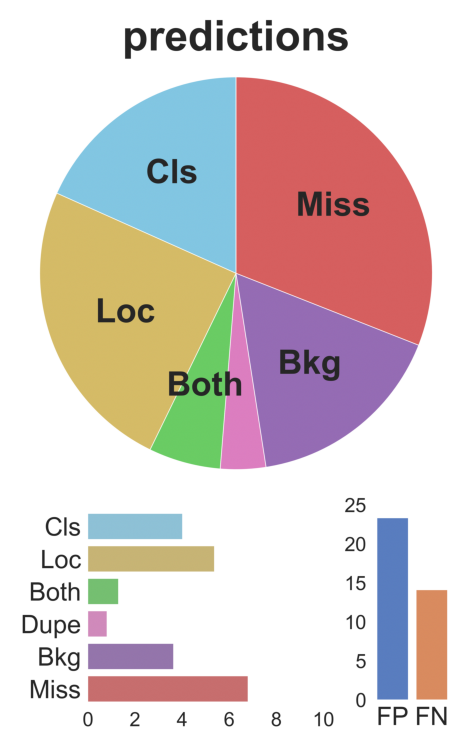

In [ ]:
%matplotlib inline
tide = TIDE()
tide.evaluate(datasets.COCO(), datasets.COCOResult(predictions_json), mode=TIDE.BOX)
tide.summarize()
tide.plot()

## Size-based analysis.

## Starter Code: Spatial Grid data structure.


## Spatial Grid Implementation

The `SpatialGrid` class implements a spatial indexing data structure that helps efficiently find nearby objects. Using this data structure is useful for our size-based analysis as it significantly reduces the time complexity of finding overlapping boxes.

### How it works:
1. The image space is divided into a grid of cells. The size of the cells is defined by the `cell_size` parameter.
2. Each bounding box is mapped to the cells it overlaps.
3. When searching for nearby objects, we only need to check objects in the relevant grid cells.

### Usage Example:
```python
grid = SpatialGrid(cell_size=100)
grid.add_box(0, [100, 100, 200, 200])  # Add a box with index 0, and bbox coordinates [100, 100, 200, 200]
nearby = grid.get_nearby_indices([150, 150, 250, 250])  # Find boxes near the bbox [150, 150, 250, 250]
```

In [ ]:
class SpatialGrid:
    def __init__(self, cell_size: int = 100):
        """A spatial indexing structure for efficient nearby object queries.

        This data structure divides 2D space into a grid and maintains a mapping of
        which objects overlap with each grid cell, enabling efficient spatial queries.
        """
        self.cell_size: int = cell_size
        # self.grid = defaultdict(list)
        self.grid: Dict[Tuple[int, int], List[int]] = defaultdict(list)

    def get_cell_coords(self, bbox: np.ndarray) -> Set[Tuple[int, int]]:
        """Get all grid cells that a bounding box overlaps with.

        Args:
            bbox: Bounding box coordinates [x1, y1, x2, y2]
                where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner

        Returns:
            Set of (x, y) grid cell coordinates
        """
        x1, y1, x2, y2 = bbox
        start_x = int(x1 // self.cell_size)
        end_x = int(x2 // self.cell_size)
        start_y = int(y1 // self.cell_size)
        end_y = int(y2 // self.cell_size)
        return {(i, j) for i in range(start_x, end_x + 1)
                       for j in range(start_y, end_y + 1)}

    def add_box(self, idx: int, bbox: np.ndarray):
        """Add a bounding box to the spatial grid.

        Args:
            idx: Index of the bounding box
            bbox: Bounding box coordinates [x1, y1, x2, y2]
        """
        cells = self.get_cell_coords(bbox)
        for cell in cells:
            self.grid[cell].append(idx)

    def get_nearby_indices(self, bbox: np.ndarray) -> Set[int]:
        """Get indices of bounding boxes that are near the given bounding box.

        Args:
            bbox: Bounding box coordinates [x1, y1, x2, y2]

        Returns:
            Set of indices of nearby bounding boxes
        """
        cells = self.get_cell_coords(bbox)
        nearby = set()
        for cell in cells:
            nearby.update(self.grid[cell])
        return nearby

In [ ]:
# Size thresholds as per COCO
SMALL_THRESH = 32 * 32
MEDIUM_THRESH = 96 * 96

## Your task: Implement the size-based ECE computation.

## Solution:

# Size-based TIDE computation:

## Solution: